### Imports

Necessary imports.

In [35]:
import random
import logging
from typing import Callable
from collections import namedtuple
from matplotlib import pyplot as plt

logging.getLogger().setLevel(logging.INFO)

### Definition of the problem

Definition of the Set Covering problem with the homonym function. 

In [36]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

### Useful functions and parameters

I decided to use some global variables and data structures that can be used below in the other chuncks of code: <br>
* GENERATIONS_NUMBER is the maximum number of generations that I want my algorithm explores. <br>
* POPULATION_SIZE is the number of individual a single population has to own. <br>
* OFFSPRING_SIZE is the amount of new individuals my algorithm has to generate for each generation. <br>
* PROBLEM_NUMBER is the dimension of Set Covering problem. <br>
* GOAL is the complete set with PROBLEM_NUMBER members (the final state of the solution). <br>
* Individual is a namedtuple that will be used to contain one genome and its fitness value, in other words it will represents a single individual. <br>
* sets_list is the list of set generated by the function "problem", it contains all the sets. <br>
* GENOME_LENGTH is the dimension of a single genome, so the total number of genes. <br>

I will draw the single individual as a union of the genome and its fitness. The genome will be composed by an array of boolean where the cell i, represents if this genome are keepeing or not the set number i in the sets_list. <br>

Then there are some useful function for the algorithm: <br>
* calculate_steps collapses the different lists in one single set and counts the steps (so the number of lists used). <br>
* goal_reach takes the genome and using the calculate_steps function, compares it with the GOAL variable. <br>
* calculate_fintess checks what sets are keeping by a certain genome and by taking in count the numbers repetitions, the length of the sets and the number of sets, calculates the fitness value for the individual. <br>
* tournament takes the randomly n elements of a population, where n is decided by the user (default is 2), and with respect to their fitnesses, one (in case of mutation, flag='m') or two (in case of crossover, flag='c') of them is/are selected. <br>
* mutation randomly changes the genome of an individual (it changes the boolean values of the list). I added the already_modified list to guide a bit the process (to not modify always the same values). <br>
* crossover randomly merges two genomes with an operation of cut and paste. <br>

In [37]:
GENERATIONS_NUMBER = 50
POPULATION_SIZE = 10
OFFSPRING_SIZE = 100
PROBLEM_NUMBER = 50
GOAL = set(range(PROBLEM_NUMBER))
Individual = namedtuple("Individual", ["genome", "fitness"])
sets_list = problem(PROBLEM_NUMBER, seed=42)
GENOME_LENGTH = len(sets_list)

def calculate_steps(genome: list):
    solution = list()
    steps = 0
    for i,gene in enumerate(genome):
        if gene == True:
            solution.append(sets_list[i])
            steps += 1
    return solution, steps
    
def goal_reach(genome: list):
    solution = calculate_steps(genome)[0]
    final_set = set()
    for s in solution:
        final_set.update(s)
    return final_set == GOAL

def calculate_fitness(inner_genome: list):
    composed_set = set()
    total_weight = 0
    repeated_elements = 0
    sets_number = 0
    bonus = 0
    for i,gene in enumerate(inner_genome):
        if gene == True:
            s = set(sets_list[i])
            repeated_elements += len((composed_set.intersection(s)))
            composed_set = composed_set.union(s)
            sets_number += 1
    if goal_reach(composed_set) == True:
        bonus = PROBLEM_NUMBER
    return len(composed_set)-repeated_elements+bonus

def tournament(population: list, flag, tournament_size=2):
    if flag == 'm':
        return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)
    elif flag == 'c':
        choices = random.choices(population, k=tournament_size)
        choices.sort(key=lambda i: i.fitness, reverse=True)
        return choices[:2]

def mutation(genome: list, false_value=0.9, true_value=0.3):
    while random.random() < false_value:
        tr = random.randint(0, GENOME_LENGTH-1)
        genome[tr] = False
    while random.random() < true_value:
        tr = random.randint(0, GENOME_LENGTH-1)
        genome[tr] = True
    return genome

def crossover(genome_1: list, genome_2: list):
    cut = random.randint(0, GENOME_LENGTH-1)
    return genome_1[:cut] + genome_2[cut:]


### Define initial population

In this section I randomly initialize the population genomes and set the initial fitness value to zero for each individual. Then I calculate the fitness for each one.

In [38]:
#population = [Individual(genome=[False for _ in range(GENOME_LENGTH)], fitness=0.0) for i in range(POPULATION_SIZE)]
population_zeroed = [Individual(genome=[random.choice([False, True]) for _ in range(GENOME_LENGTH)], fitness=0.0) for i in range(POPULATION_SIZE)]
population = [Individual(genome=item.genome, fitness=calculate_fitness(item.genome)) for item in population_zeroed]

### Evolution

This section is the core of the algorithm, and the main strategies are: <br>
* I apply a random choice between mutation and crossover and for each generation I make a new population that is the same as the generation before plus the offspring list (made by mutations and crossovers of the individuals genomes). Since we have a maximum individuals in each population (i.e. POPULATION_SIZE), I sort the population vector and keep only the first POPULATION_SIZE elements for the next generation <br>
* Obviously the new individuals have a new fitness value calculated after the changements in their genome. <br>
* I add a fitness_log data structure that will be useful for the plots. <br>
* The data structure best_solution_genome, is used for a simple maximum search (based on the genomes' fitnesses) when the algorithm reaches a local solution.

In [39]:
fitness_log = [(0, i.fitness) for i in population]
offspring = list()
best_solution = [-10_000, list()]
false_value = 0.9
true_value = 0.1

for generation in range(GENERATIONS_NUMBER):
    offspring = list()
    if generation > round(GENERATIONS_NUMBER/2):
        false_value = 0.7
        true_value = 0.5
    for i in range(OFFSPRING_SIZE):
        if random.random() < 0.3:
            selected_parent = tournament(population, tournament_size=3, flag='m')
            new_genome = mutation(selected_parent.genome, false_value=false_value, true_value=true_value)
        else:
            selected_parents = tournament(population, tournament_size=3, flag='c')
            new_genome_c = crossover(selected_parents[0].genome, selected_parents[1].genome)
            new_genome = mutation(new_genome_c, false_value=false_value, true_value=true_value)
        new_fitness = calculate_fitness(new_genome)
        while (new_genome, new_fitness) in offspring or (new_genome, new_fitness) in population:
            new_genome = mutation(new_genome, false_value=false_value, true_value=true_value)
            new_fitness = calculate_fitness(new_genome)
        fitness_log.append((generation + 1, new_fitness))
        offspring.append(Individual(new_genome, new_fitness))
        if new_fitness > best_solution[0] and goal_reach(new_genome):
            best_solution[0] = new_fitness
            best_solution[1] = new_genome.copy()
    population += offspring
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]

### Performances

Here I expose the result of my algorithm, both in numeric terms and in plots terms.

INFO:root: Find a solution in 7 steps; Total weight: 106; (bloat=112%)


[[1, 4, 41, 42, 12, 14, 17, 49, 19, 21, 22, 25, 29], [33, 35, 38, 7, 39, 14, 15, 48, 49, 24, 26], [3, 4, 5, 6, 10, 11, 13, 15, 16, 19, 27, 28, 35, 36, 37, 39, 40, 42, 47, 48], [33, 2, 36, 37, 5, 40, 41, 11, 48, 17, 22, 27, 28, 30, 31], [32, 35, 6, 8, 45, 46, 15, 48, 20, 22, 23, 25], [0, 1, 6, 9, 11, 12, 15, 16, 17, 18, 22, 27, 32, 33, 34, 39, 43, 44, 46], [32, 34, 3, 36, 5, 8, 10, 43, 44, 46, 15, 48, 47, 21, 22, 24]]


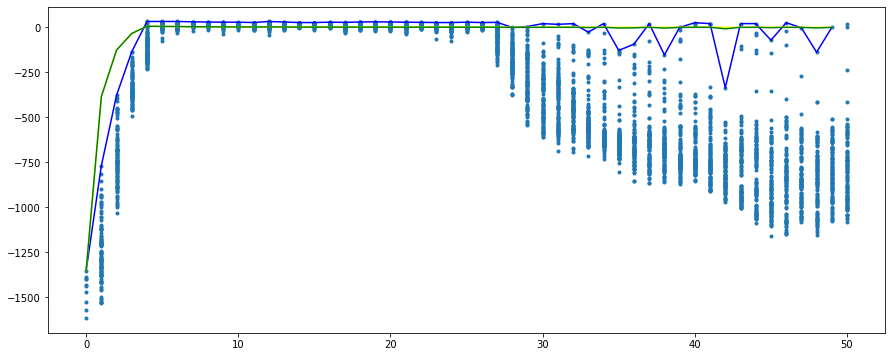

In [40]:
if best_solution[1] != []:
    solution, steps = calculate_steps(best_solution[1])
    logging.info(
        f" Find a solution in {steps} steps; "
        f"Total weight: {sum(len(_) for _ in solution)}; "
        f"(bloat={(sum(len(_) for _ in solution)-PROBLEM_NUMBER)/PROBLEM_NUMBER*100:.0f}%)"
    )
else:
    logging.info(
        f"Solution not found!"
    )
print(solution)
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(GENERATIONS_NUMBER)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(GENERATIONS_NUMBER)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(GENERATIONS_NUMBER)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)], color='blue')
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)], color='yellow')
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)], color='green')